## Import All required Libraries

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input,GlobalAveragePooling2D

## Loading Datasets

In [44]:
train_csv_path = "/kaggle/input/emnist/emnist-letters-train.csv"
test_csv_path = "/kaggle/input/emnist/emnist-letters-test.csv"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

train_labels = train_df.iloc[:, 0].values
train_images = train_df.iloc[:, 1:].values
test_labels = test_df.iloc[:, 0].values
test_images = test_df.iloc[:, 1:].values


## Handling Missing Classes in Test Data

In [45]:
train_classes = np.unique(train_labels)
test_classes = np.unique(test_labels)
missing_classes = np.setdiff1d(train_classes, test_classes)
print(f"Classes in training set but missing in test set: {missing_classes}")

if len(missing_classes) > 0:
    additional_test_images = []
    additional_test_labels = []
    for cls in missing_classes:
        cls_indices = np.where(train_labels == cls)[0]
        cls_train_indices, cls_test_indices = train_test_split(
            cls_indices, test_size=0.2, random_state=42
        )
        additional_test_images.append(train_images[cls_test_indices])
        additional_test_labels.append(train_labels[cls_test_indices])
        train_images = np.delete(train_images, cls_test_indices, axis=0)
        train_labels = np.delete(train_labels, cls_test_indices, axis=0)
    additional_test_images = np.concatenate(additional_test_images, axis=0)
    additional_test_labels = np.concatenate(additional_test_labels, axis=0)
    test_images = np.concatenate((test_images, additional_test_images), axis=0)
    test_labels = np.concatenate((test_labels, additional_test_labels), axis=0)

Classes in training set but missing in test set: [20 21 22 23 24 25 26]


## Preprocessing Images and Labels

In [46]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)
train_images = train_images / 255.0
test_images = test_images / 255.0

# def resize_images_in_batches(images, target_size):
#     resized_images = []
#     for batch in tf.data.Dataset.from_tensor_slices(images).batch(32):  # Adjust batch size as needed
#         resized_batch = tf.image.resize(batch, target_size)
#         resized_images.append(resized_batch)
#     return tf.concat(resized_images, axis=0)

# train_images_resized = resize_images_in_batches(train_images, (71, 71))
# test_images_resized = resize_images_in_batches(test_images, (71, 71))
with tf.device('/CPU:0'):
    train_images_resized = tf.image.resize(train_images, (71, 71))
    test_images_resized = tf.image.resize(test_images, (71, 71))

# train_images_resized = tf.image.resize(train_images, (71, 71))
# test_images_resized = tf.image.resize(test_images, (71, 71))

with tf.device('/CPU:0'):
    train_images_rgb = tf.image.grayscale_to_rgb(train_images_resized)
    test_images_rgb = tf.image.grayscale_to_rgb(test_images_resized)
# train_images_rgb = tf.image.grayscale_to_rgb(train_images_resized)
# test_images_rgb = tf.image.grayscale_to_rgb(test_images_resized)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)
train_labels_categorical = to_categorical(train_labels_encoded, num_classes)
test_labels_categorical = to_categorical(test_labels_encoded, num_classes)

## Data Augmentation

In [47]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(train_images_rgb)

## Building the Xception Model

In [48]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(71, 71, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## Training the Model

In [49]:
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    datagen.flow(train_images_rgb, train_labels_categorical, batch_size=64),
    validation_data=(test_images_rgb, test_labels_categorical),
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734526518.666089      94 service.cc:145] XLA service 0x784448012940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734526518.666181      94 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734526518.666187      94 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1313 ━━━━━━━━━━━━━━━━━━━━ 1:26 66ms/step - accuracy: 0.0234 - loss: 4.8032  

I0000 00:00:1734526529.016217      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 154s 105ms/step - accuracy: 0.3997 - loss: 2.0944 - val_accuracy: 0.7324 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 124s 94ms/step - accuracy: 0.6379 - loss: 1.1600 - val_accuracy: 0.7546 - val_loss: 0.7706 - learning_rate: 0.0010
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 123s 93ms/step - accuracy: 0.6727 - loss: 1.0341 - val_accuracy: 0.7951 - val_loss: 0.6498 - learning_rate: 0.0010
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 125s 95ms/step - accuracy: 0.6991 - loss: 0.9543 - val_accuracy: 0.8098 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 124s 94ms/step - accuracy: 0.7128 - loss: 0.9226 - val_accuracy: 0.8088 - val_loss: 0.6034 - learning_rate: 0.0010
Epoch 6/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 125s 95ms/step - accuracy: 0.7211 - loss: 0.8899 - val_accuracy: 0.8236 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 7/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 125s 95ms/step - accuracy:

## Fine-Tuning

In [50]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_fine_tune = model.fit(
    datagen.flow(train_images_rgb, train_labels_categorical, batch_size=64),
    validation_data=(test_images_rgb, test_labels_categorical),
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 238s 151ms/step - accuracy: 0.6879 - loss: 1.1855 - val_accuracy: 0.9315 - val_loss: 0.2051 - learning_rate: 1.0000e-04
Epoch 2/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 178s 135ms/step - accuracy: 0.9161 - loss: 0.2740 - val_accuracy: 0.9414 - val_loss: 0.1796 - learning_rate: 1.0000e-04
Epoch 3/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 177s 134ms/step - accuracy: 0.9295 - loss: 0.2257 - val_accuracy: 0.9424 - val_loss: 0.1703 - learning_rate: 1.0000e-04
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 177s 134ms/step - accuracy: 0.9379 - loss: 0.1971 - val_accuracy: 0.9401 - val_loss: 0.1827 - learning_rate: 1.0000e-04
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 176s 134ms/step - accuracy: 0.9410 - loss: 0.1875 - val_accuracy: 0.9469 - val_loss: 0.1649 - learning_rate: 1.0000e-04
Epoch 6/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 177s 134ms/step - accuracy: 0.9451 - loss: 0.1722 - val_accuracy: 0.9442 - val_loss: 0.1704 - learning_rate: 1.0000e-04
Epoch 7/20
1313/1313 ━━━━━━━

## Model Evaluation and Saving

In [51]:
test_loss, test_accuracy = model.evaluate(test_images_rgb, test_labels_categorical, batch_size=64)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

model.save("emnist_densenet_model.h5")
print("Model training complete and saved as 'emnist_densenet_model.h5'.")

307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9567 - loss: 0.1653
Test Loss: 0.1584
Test Accuracy: 0.9548
Model training complete and saved as 'emnist_densenet_model.h5'.


##  Accuracy and Loss Trends Across Epochs

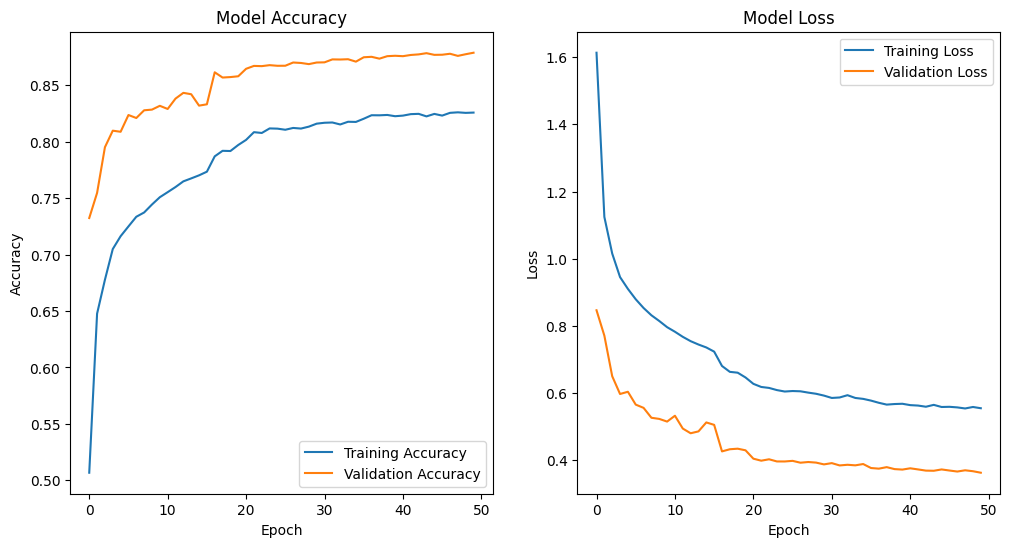

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Confusion Matrix with Alphabetic Class Labels

613/613 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step


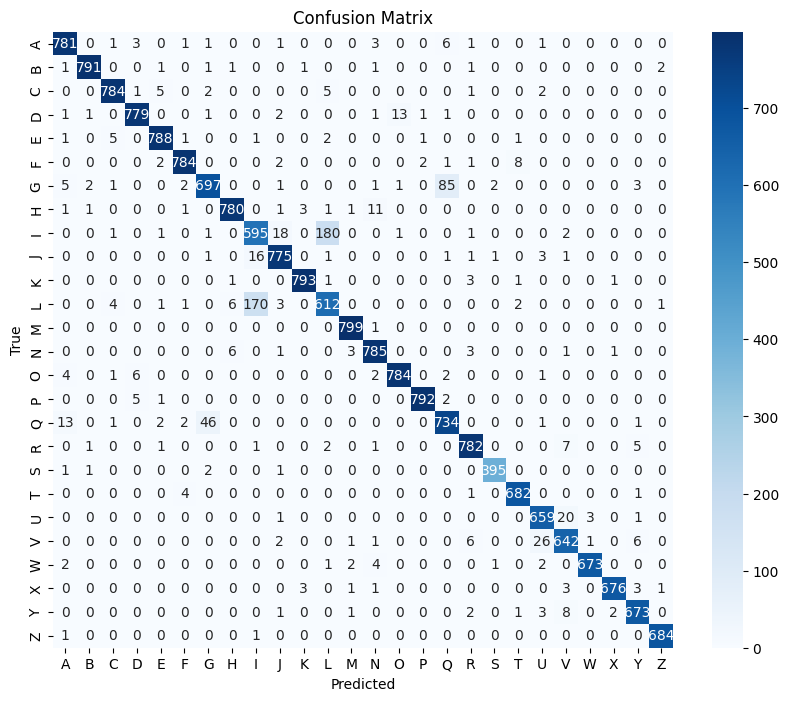

In [54]:
class_mapping = {i: chr(64 + i) for i in range(1, 27)}

alphabetic_classes = [class_mapping[i] for i in label_encoder.classes_]

predictions = np.argmax(model.predict(test_images_rgb), axis=1)
conf_matrix = confusion_matrix(test_labels_encoded, predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=alphabetic_classes, yticklabels=alphabetic_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Classification Report with Alphabetic Class Labels

In [55]:
class_mapping = {i: chr(65 + i) for i in range(26)}

alphabetic_predictions = [class_mapping[p] for p in predictions]
alphabetic_true_labels = [class_mapping[t] for t in test_labels_encoded]

report = classification_report(
    alphabetic_true_labels,
    alphabetic_predictions,
    target_names=[class_mapping[i] for i in range(len(class_mapping))]
)
print(report)

              precision    recall  f1-score   support

           A       0.96      0.98      0.97       799
           B       0.99      0.99      0.99       800
           C       0.98      0.98      0.98       800
           D       0.98      0.97      0.98       800
           E       0.98      0.98      0.98       800
           F       0.98      0.98      0.98       800
           G       0.93      0.87      0.90       800
           H       0.98      0.97      0.98       800
           I       0.76      0.74      0.75       800
           J       0.96      0.97      0.96       800
           K       0.99      0.99      0.99       800
           L       0.76      0.77      0.76       800
           M       0.99      1.00      0.99       800
           N       0.97      0.98      0.97       800
           O       0.98      0.98      0.98       800
           P       0.99      0.99      0.99       800
           Q       0.88      0.92      0.90       800
           R       0.97    

## Multiclass ROC Curve and Micro-average AUC Calculation

613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step


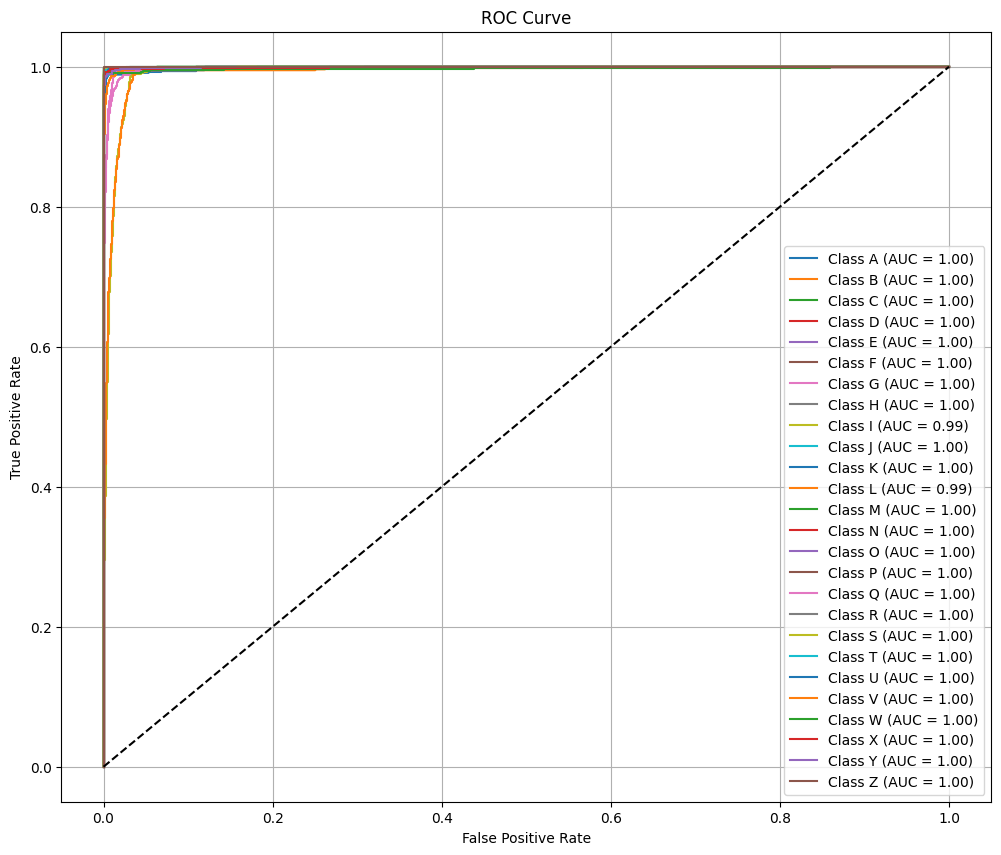

Micro-average AUC: 1.00


In [56]:
y_pred_proba = model.predict(test_images_rgb)
y_test_binarized = label_binarize(test_labels_encoded, classes=np.arange(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
for i, label in enumerate(alphabetic_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

print(f"Micro-average AUC: {roc_auc_micro:.2f}")